acceptance rate: 0.1815
Predicted Value of alpha at 0.3 is 0.45
Predicted Value of beta at 6.0 is 2.89
Predicted Value of gamma at 10.5 is 19.65
acceptance rate: 0.09816
Predicted Value of alpha at 0.3 is 0.29
Predicted Value of beta at 6.0 is 8.83
Predicted Value of gamma at 10.5 is 9.88
acceptance rate: 0.12164
Predicted Value of alpha at 0.3 is 0.34
Predicted Value of beta at 6.0 is 9.91
Predicted Value of gamma at 10.5 is 13.36


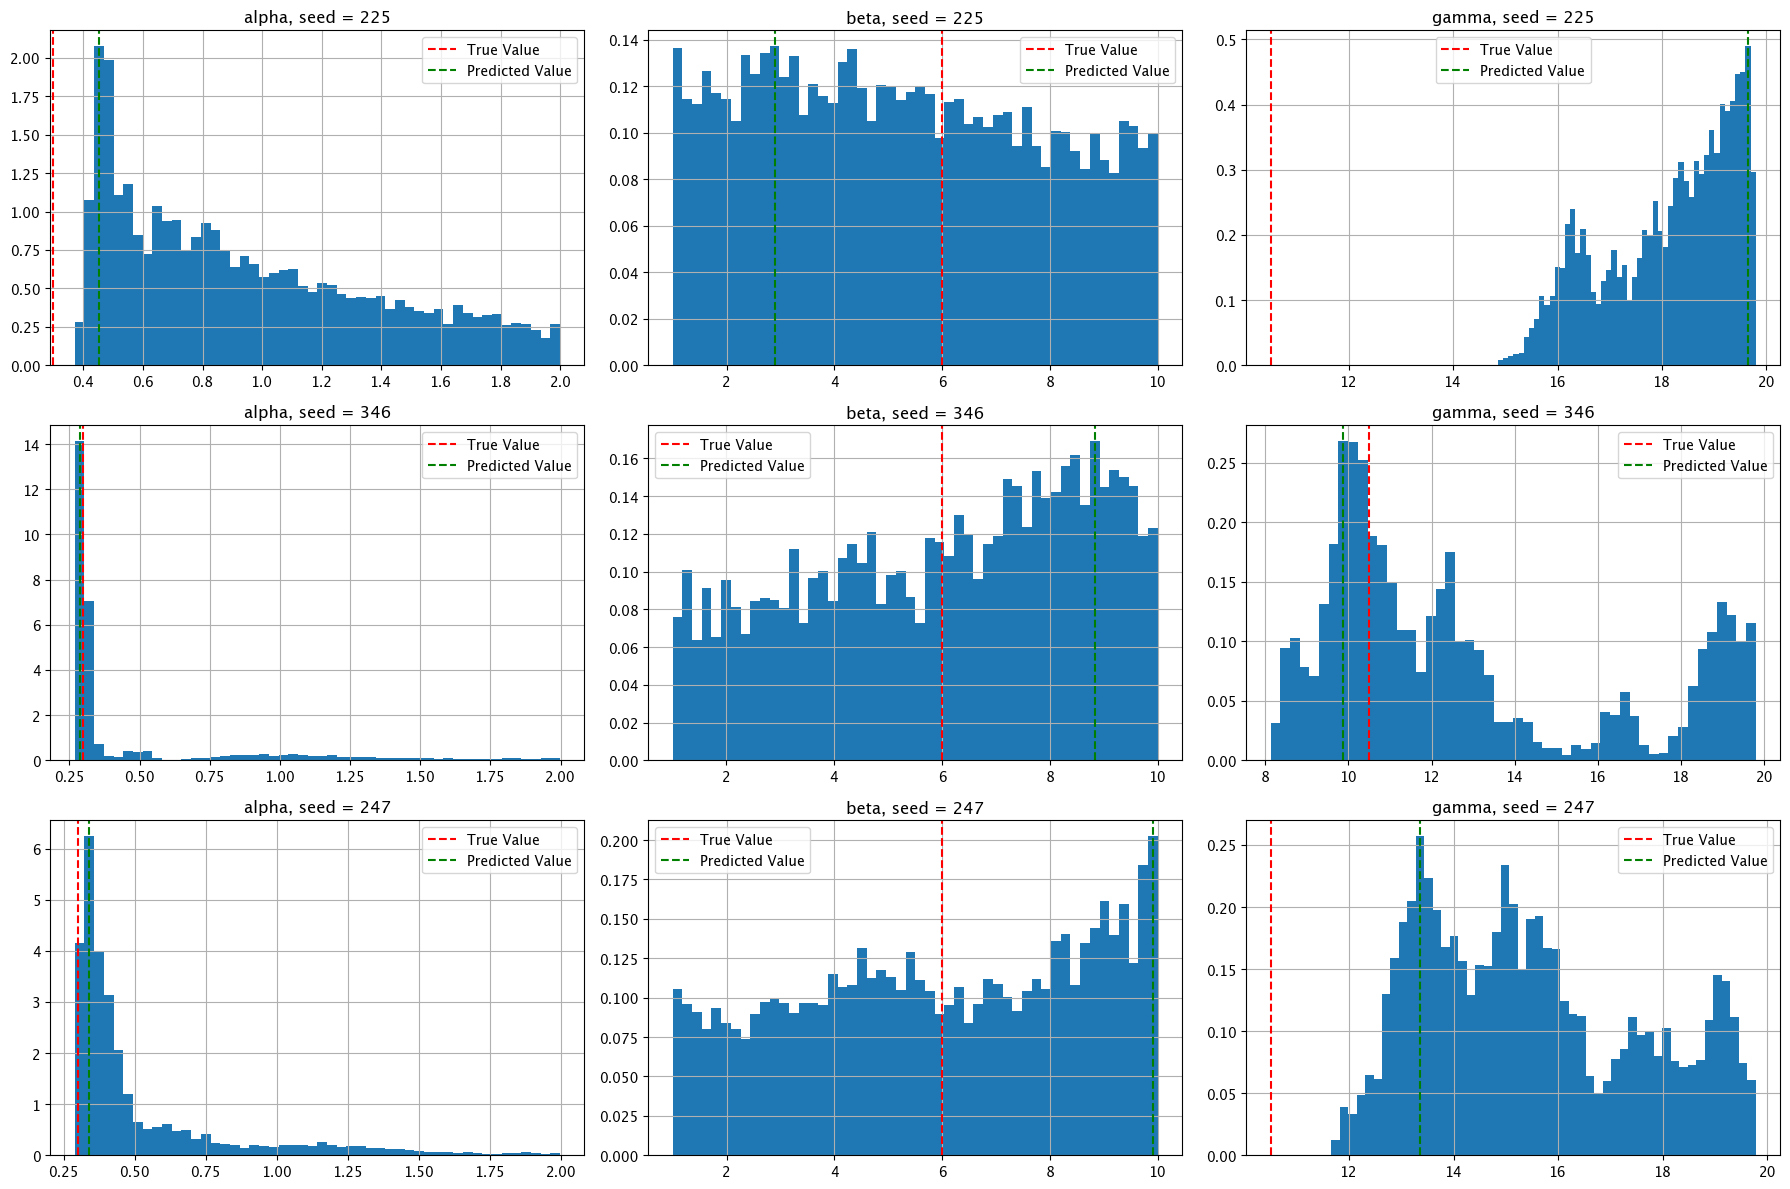

In [110]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. True model and data generation ---
true_params = np.array([0.3, 6.0, 10.5])
def true_model(t, alpha=true_params[0], beta=true_params[1], gamma=true_params[2]):
    return alpha * np.exp(t) * (1 - np.tanh(2*(t - beta)) ) * np.sin(gamma * t)

t = np.linspace(0, 15, 100)
y_true = true_model(t)
bound_value = 100
good_points = np.where((-bound_value < y_true) & (y_true <  bound_value), 1, 0)
t = t[good_points]
y_true = y_true[good_points]
# 20% noise
y_err = 0.2 * y_true + 1e-9 # Division error protection
y_data = y_true + np.random.normal(0, np.abs(y_err))

# --- 2. Model function ---
def model(t, theta):
    alpha, beta, gamma = theta
    # Actual function to try, doesn't work right now because of high complexity
    return alpha * np.exp(t) * (1 - np.tanh(2*(t - beta)) ) * np.sin(gamma * t)
    # return alpha * np.exp(-beta * t) + gamma

# --- 3. Log-likelihood function ---
def log_likelihood(theta):
    y_model = model(t, theta)
    chi2 = np.sum(((y_data - y_model) / y_err)**2)
    return -0.5 * chi2

# --- 4. Proposal function ---
def propose(theta, sigma):
    return theta + np.random.normal(0, sigma)  # small step

# Bounded Check
def bounded(theta):
    if (0 < theta[0] < 2) and (1 < theta[1] < 10) and (1 < theta[2] < 20):
        return 1
    return 0


# --- 5. Metropolis–Hastings sampling ---
def MHSampling(seed):
    acceptance_count_theta = 0
    np.random.seed(seed)
    theta = np.array([np.random.randint(1,9)*0.1, np.random.randint(12,98)*0.1, np.random.randint(12, 198)*0.1])
    chain = [theta]
    logL = log_likelihood(theta)
    N = 100000
    burn_in = N/5
    for i in range(N):
        theta_new = propose(theta, [0.1, 0.5, 0.1])
        # uniform prior check: only accept if parameters in range
        if bounded(theta_new) == 0:
            if i > burn_in: chain.append(theta)
            continue
        logL_new = log_likelihood(theta_new)
        A = np.exp(np.minimum(0, logL_new - logL))
        if np.random.rand() < A:
            acceptance_count_theta += 1
            theta, logL = theta_new, logL_new
        if i > burn_in: chain.append(theta)

    chain = np.array(chain)
    acceptance_rate = acceptance_count_theta / N
    print(f'acceptance rate: {acceptance_rate}')
    return chain

# --- 6. Results ---
fig, ax = plt.subplots(3, 3, figsize=(18, 12))
labels = ['alpha', 'beta', 'gamma']
for j in range(3):
    seed = int(1000*np.random.random())
    MH_chain = MHSampling(seed=seed)
    for i in range(3):
        # Compute histogram first
        counts, bins = np.histogram(MH_chain[:, i], bins=50)

        # Plot the histogram
        ax[j,i].hist(MH_chain[:, i], bins=50, density=True)
        ax[j,i].set_title(f"{labels[i]}, seed = {seed}")
        ax[j,i].axvline(true_params[i], color='r', linestyle='--', label="True Value")

        # Find the bin with maximum count (mode)
        max_count_idx = np.argmax(counts)
        # Get the center of that bin
        pred_value = (bins[max_count_idx] + bins[max_count_idx + 1]) / 2

        ax[j,i].axvline(pred_value, color='g', linestyle='--', label='Predicted Value')
        print(f"Predicted Value of {labels[i]} at {true_params[i]} is {pred_value:.2f}")
        ax[j,i].legend()
        ax[j,i].grid(True)
plt.tight_layout()
plt.show()


acceptance rate (all params): 0.21986
Predicted value of alpha: 0.368
acceptance rate (beta,gamma): 0.64218


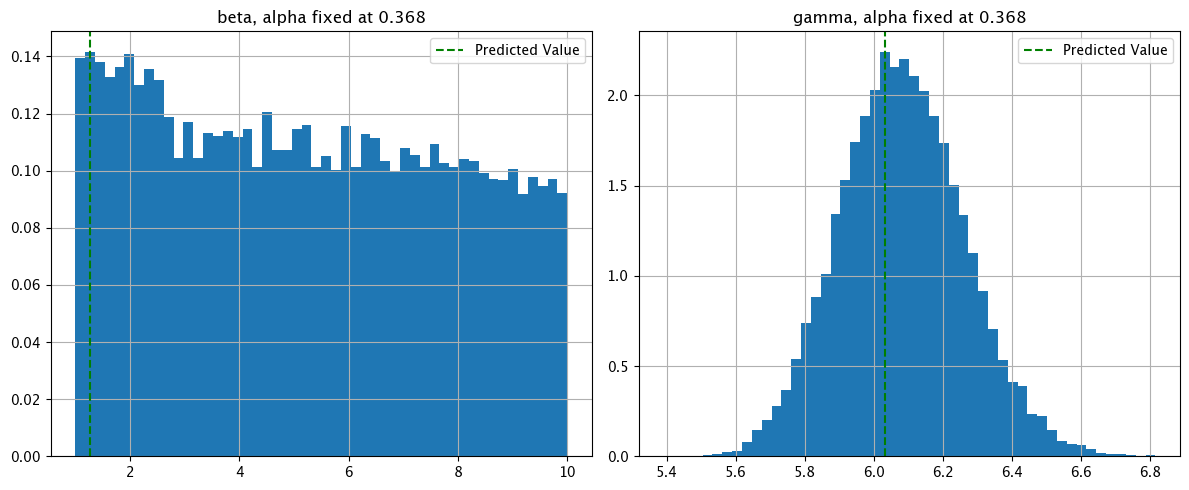

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. True model and data generation ---
true_params = np.array([0.3, 6.0, 10.5])
def true_model(t, alpha=true_params[0], beta=true_params[1], gamma=true_params[2]):
    return alpha * np.exp(t) * (1 - np.tanh(2*(t - beta))) * np.sin(gamma * t)

t = np.linspace(0, 15, 100)
y_true = true_model(t)
bound_value = 100
good_points = np.where((-bound_value < y_true) & (y_true <  bound_value), 1, 0)
t = t[good_points]
y_true = y_true[good_points]
y_err = 0.2 * y_true + 1e-9
y_data = y_true + np.random.normal(0, np.abs(y_err))

# --- 2. Model with fixed alpha ---
def model_fixed_alpha(t, beta_gamma, alpha_fixed):
    beta, gamma = beta_gamma
    return alpha_fixed * np.exp(t) * (1 - np.tanh(2*(t - beta)) ) * np.sin(gamma * t)

def log_likelihood_fixed(beta_gamma, alpha_fixed):
    y_model = model_fixed_alpha(t, beta_gamma, alpha_fixed)
    chi2 = np.sum(((y_data - y_model) / y_err)**2)
    return -0.5 * chi2

def propose(beta_gamma, sigma):
    return beta_gamma + np.random.normal(0, sigma)

def bounded(bg):
    return (1 < bg[0] < 10) and (1 < bg[1] < 20)

# 3. Find alpha mode from chain
def find_pred_alpha(MH_chain):
    counts, bins = np.histogram(MH_chain[:, 0], bins=50)
    max_count_idx = np.argmax(counts)
    pred_alpha = (bins[max_count_idx] + bins[max_count_idx + 1]) / 2
    return pred_alpha

# --- 4. Metropolis-Hastings for beta, gamma with alpha fixed ---
def MHSampling_fixed_alpha(alpha_fixed, seed):
    acceptance_count_theta = 0
    np.random.seed(seed)
    beta_gamma = np.array([np.random.uniform(2,8), np.random.uniform(2,16)])
    chain = [beta_gamma]
    logL = log_likelihood_fixed(beta_gamma, alpha_fixed)
    N = 50000
    burn_in = N // 5
    for i in range(N):
        beta_gamma_new = propose(beta_gamma, [0.5, 0.2])
        if not bounded(beta_gamma_new):
            if i > burn_in: chain.append(beta_gamma)
            continue
        logL_new = log_likelihood_fixed(beta_gamma_new, alpha_fixed)
        A = np.exp(np.minimum(0, logL_new - logL))
        if np.random.rand() < A:
            acceptance_count_theta += 1
            beta_gamma, logL = beta_gamma_new, logL_new
        if i > burn_in: chain.append(beta_gamma)
    chain = np.array(chain)
    acceptance_rate = acceptance_count_theta / N
    print(f'acceptance rate (beta,gamma): {acceptance_rate}')
    return chain

# --- 5. Run standard MCMC to get alpha chain ---
seed = int(1000*np.random.random())
def MHSampling_alpha(seed):
    acceptance_count_theta = 0
    np.random.seed(seed)
    theta = np.array([np.random.uniform(0.1,1.5), np.random.uniform(2,8), np.random.uniform(2,16)])
    chain = [theta]
    logL = log_likelihood(theta)
    N = 50000
    burn_in = N // 5
    for i in range(N):
        theta_new = propose(theta, [0.05, 0.1, 0.1])
        if not (0 < theta_new[0] < 2 and 1 < theta_new[1] < 10 and 1 < theta_new[2] < 20):
            if i > burn_in: chain.append(theta)
            continue
        logL_new = log_likelihood(theta_new)
        A = np.exp(np.minimum(0, logL_new - logL))
        if np.random.rand() < A:
            acceptance_count_theta += 1
            theta, logL = theta_new, logL_new
        if i > burn_in: chain.append(theta)
    chain = np.array(chain)
    acceptance_rate = acceptance_count_theta / N
    print(f'acceptance rate (all params): {acceptance_rate}')
    return chain

MH_chain_alpha = MHSampling_alpha(seed)
pred_alpha = find_pred_alpha(MH_chain_alpha)
print(f"Predicted value of alpha: {pred_alpha:.3f}")

# --- 6. Run chain for beta/gamma with alpha fixed ---
MH_chain_bg = MHSampling_fixed_alpha(pred_alpha, seed+1)
labels = ['beta', 'gamma']

# --- 7. Plotting ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    counts, bins = np.histogram(MH_chain_bg[:, i], bins=50)
    ax[i].hist(MH_chain_bg[:, i], bins=50, density=True)
    ax[i].set_title(f"{labels[i]}, alpha fixed at {pred_alpha:.3f}")
    ax[i].grid(True)
    max_count_idx = np.argmax(counts)
    pred_value = (bins[max_count_idx] + bins[max_count_idx + 1]) / 2
    ax[i].axvline(pred_value, color='g', linestyle='--', label='Predicted Value')
    ax[i].legend()
plt.tight_layout()
plt.show()


All parameters free: alpha | True: 0.300 | Pred: 0.287
All parameters free: beta | True: 7.000 | Pred: 9.909
All parameters free: gamma | True: 10.500 | Pred: 9.578


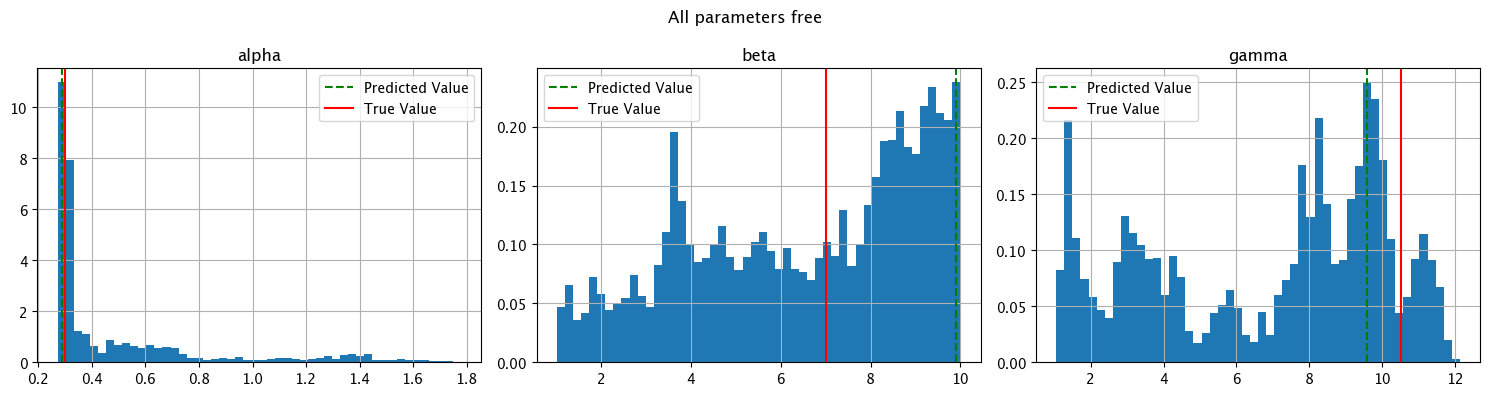

beta, gamma | alpha fixed: beta | True: 7.000 | Pred: 7.051
beta, gamma | alpha fixed: gamma | True: 10.500 | Pred: 10.497


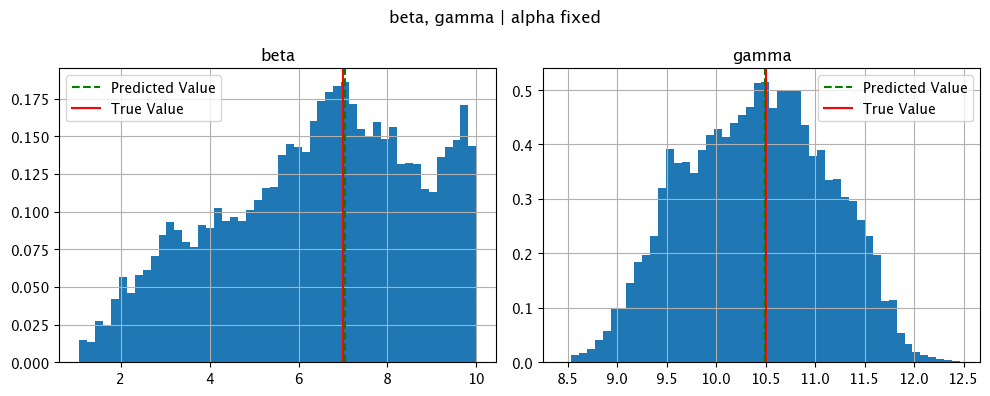

beta | alpha, gamma fixed: beta | True: 7.000 | Pred: 6.132


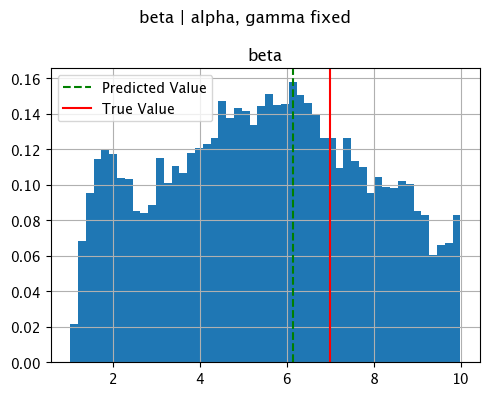


SUMMARY TABLE
Stage                      alpha       beta      gamma
True values                0.300      7.000     10.500
All params free            0.287      9.909      9.578
alpha fixed                0.287      7.051     10.497
alpha, gamma fixed         0.287      6.132     10.497


In [113]:
import numpy as np
import matplotlib.pyplot as plt

# --- Model and data generation ---
true_params = np.array([0.3, 7.0, 10.5])
def true_model(t, alpha=true_params[0], beta=true_params[1], gamma=true_params[2]):
    return alpha * np.exp(t) * (1 - np.tanh(2*(t - beta))) * np.sin(gamma * t)

t = np.linspace(0, 15, 100)
y_true = true_model(t)
bound_value = 100
good_points = np.where((-bound_value < y_true) & (y_true <  bound_value), 1, 0)
t = t[good_points]
y_true = y_true[good_points]
y_err = 0.2 * y_true + 1e-9
y_data = y_true + np.random.normal(0, np.abs(y_err))

labels = ["alpha", "beta", "gamma"]

def model(t, theta):
    alpha, beta, gamma = theta
    return alpha * np.exp(t) * (1 - np.tanh(2 * (t - beta))) * np.sin(gamma * t)

def log_likelihood(theta):
    y_model = model(t, theta)
    chi2 = np.sum(((y_data - y_model) / y_err) ** 2)
    return -0.5 * chi2

def propose(theta, sigma):
    return theta + np.random.normal(0, sigma)

def in_bounds(theta):
    a, b, c = theta
    return 0 < a < 2 and 1 < b < 10 and 1 < c < 20

def mh_sample(loglik_fn, start, prop_sigma, bounds_fn, n_sample=20000, burn=5000):
    chain = []
    theta = start
    logL = loglik_fn(theta)
    accept = 0
    for i in range(n_sample + burn):
        theta_new = propose(theta, prop_sigma)
        if not bounds_fn(theta_new):
            if i >= burn:
                chain.append(theta)
            continue
        logL_new = loglik_fn(theta_new)
        A = np.exp(np.minimum(0, logL_new - logL))
        if np.random.rand() < A:
            theta, logL = theta_new, logL_new
            accept += 1
        if i >= burn:
            chain.append(theta)
    return np.array(chain), accept / (n_sample + burn)

def report_and_plot(chain, labels, true_vals, title):
    # Mode estimate (histogram bin with max count)
    preds = []
    fig, axs = plt.subplots(1, len(labels), figsize=(5*len(labels), 4))
    for i in range(len(labels)):
        counts, bins = np.histogram(chain[:, i], bins=50)
        max_idx = np.argmax(counts)
        pred_val = (bins[max_idx] + bins[max_idx+1])/2
        preds.append(pred_val)
        ax = axs[i] if len(labels) > 1 else axs
        ax.hist(chain[:, i], bins=50, density=True)
        ax.axvline(pred_val, color="g", linestyle="--", label="Predicted Value")
        ax.axvline(true_vals[i], color="r", linestyle="-", label="True Value")
        ax.set_title(f"{labels[i]}")
        ax.legend()
        ax.grid(True)
        print(f"{title}: {labels[i]} | True: {true_vals[i]:.3f} | Pred: {pred_val:.3f}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return np.array(preds)

# ======== STAGE 1: All parameters ========
start = np.array([np.random.uniform(0.1,1.5), np.random.uniform(2,8), np.random.uniform(2,16)])
chain1, acc1 = mh_sample(log_likelihood, start, [0.05, 0.2, 0.1], in_bounds)
preds1 = report_and_plot(chain1, labels, true_params, "All parameters free")

# ======== STAGE 2: Fix alpha ========
def loglik_bc(bc):
    a = preds1[0]
    b, c = bc
    theta = [a, b, c]
    return log_likelihood(theta)

def in_bounds_bc(bc):
    b, c = bc
    return 1 < b < 10 and 1 < c < 20

start_bc = np.array([8.0, 11.0])
chain2, acc2 = mh_sample(loglik_bc, start_bc, [0.2, 0.1], in_bounds_bc)
preds2 = report_and_plot(chain2, ["beta","gamma"], true_params[1:], "beta, gamma | alpha fixed")

# ======== STAGE 3: Fix alpha & gamma ========
def loglik_b(b):
    a = preds1[0]
    c = preds2[1]
    theta = [a, b[0], c]
    return log_likelihood(theta)

def in_bounds_b(b):
    return 1 < b[0] < 10

start_b = np.array([8.0])
chain3, acc3 = mh_sample(loglik_b, start_b, [0.2], in_bounds_b)
preds3 = report_and_plot(chain3, ["beta"], [true_params[1]], "beta | alpha, gamma fixed")

# ======= Report Table ======
print("\nSUMMARY TABLE")
print(f"{'Stage':<22}{'alpha':>10} {'beta':>10} {'gamma':>10}")
print(f"{'True values':<22}{true_params[0]:>10.3f} {true_params[1]:>10.3f} {true_params[2]:>10.3f}")
print(f"{'All params free':<22}{preds1[0]:>10.3f} {preds1[1]:>10.3f} {preds1[2]:>10.3f}")
print(f"{'alpha fixed':<22}{preds1[0]:>10.3f} {preds2[0]:>10.3f} {preds2[1]:>10.3f}")
print(f"{'alpha, gamma fixed':<22}{preds1[0]:>10.3f} {preds3[0]:>10.3f} {preds2[1]:>10.3f}")
